In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt' , 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
#build a vocabulary of characters  and mappiing to/from integers
chars =sorted(list(set(''.join(words))))
stoi = {s:i+1 for i ,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
#building the dataset
block_size =3 # content length | how many words do we take to predict the next character
X,Y=[],[]

for w in words:
    # print(w)
    context=[0]*block_size
    for ch in w + '.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->' ,itos[ix])
        context=context[1:]+ [ix] #crop and append
        

X=torch.tensor(X)
Y=torch.tensor(Y)




In [5]:
X.shape ,X.dtype,Y.shape ,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #training set
Xdev, Ydev = build_dataset(words[n1:n2]) #validation set
Xte, Yte = build_dataset(words[n2:]) #test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
Xtr.shape ,Xtr.dtype,Ytr.shape ,Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [8]:
C= torch.randn((27,2))
C[5]

tensor([0.1616, 2.7033])

In [9]:
# F.one_hot(torch.tensor(5) ,num_classes=27).float() @ C

emb =C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
# torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape # it works but for blocksize 3 if we change the blocksize we have to change this to so we do this instead
# torch.cat(torch.unbind(emb,1),1)  # more effecient way to do this is intersm of storage
# emb.view((32,6))

In [11]:
W1 =torch.randn((6,100)) 
b1 =torch.randn(100)

In [12]:
h =torch.tanh(emb.view(-1,6) @ W1 +b1) #'-1' torch will infer its 32
h

tensor([[-0.7369,  0.9748, -0.5273,  ..., -0.9976,  0.9126,  0.7405],
        [-0.9952,  0.9995, -0.8427,  ..., -1.0000,  0.9663,  0.9709],
        [ 0.9755, -0.9363,  0.9503,  ...,  0.6199, -0.2729, -0.5436],
        ...,
        [ 0.9981, -0.9985,  0.9971,  ..., -0.1854, -0.9914, -0.9172],
        [-0.8239, -0.9628,  0.9914,  ..., -0.9991, -0.9835, -0.9944],
        [ 0.7073, -0.6893, -0.8679,  ...,  0.9771, -0.2679,  0.9941]])

In [13]:
W2 =torch.randn((100,27))
b2 =torch.randn(27)


In [14]:
logits =h @ W2 +b2
counts =logits.exp()
prob=counts/counts.sum(1,keepdim=True)
prob.shape


torch.Size([228146, 27])

In [15]:
prob[0].sum()

tensor(1.0000)

In [16]:
# ------------ now made respectable :) ---------------

In [17]:
X.shape ,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [18]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [19]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [20]:
for p in parameters:
    p.requires_grad =True

In [21]:
# #forward pass
# for _ in range(10):
#     emb =C[X] #[32,3,2]
#     h =torch.tanh(emb.view(-1,6) @ W1 +b1) #'-1' torch will infer its 32
#     logits =h @ W2 +b2
#     # counts =logits.exp()
#     # prob=counts/counts.sum(1,keepdim=True)
#     #   loss = -prob[torch.arange(32) ,Y].log().mean()  # there is an easy way to do this in Torch functional  F.cross_entropy
#     loss = F.cross_entropy(logits,Y)
#     # print(loss.item())



# #backward pass
#     for p in parameters:
#         p.grad=None
#     loss.backward()

# #update

#     for p in parameters:
#         p.data += -0.1 * p.grad

# print(loss.item())



In [22]:
lre=torch.linspace(-3,0,1000) #learning ratee exponent
lrs =10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [23]:
lri=[]
lossi =[]
stepi=[]

In [30]:
#above calculation is tsking too muvh time to calculate  s o optimize way is :
#forward pass

for i in range(200000):
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0] ,(32,))
    emb =C[Xtr[ix]] #[32,3,2]
    h =torch.tanh(emb.view(-1,30) @ W1 +b1) #'-1' torch will infer its 32
    logits =h @ W2 +b2
    loss = F.cross_entropy(logits,Ytr[ix])
    # print(loss.item())



#backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

#update
    # lr =lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad



# track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())



1.9899475574493408


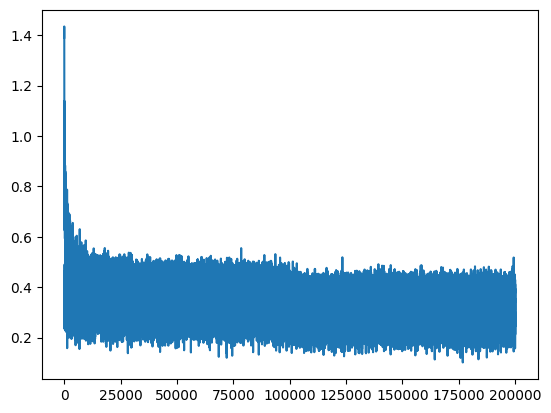

In [31]:
plt.plot(stepi,lossi)

In [32]:
emb =C[Xdev] #[32,3,2]
h =torch.tanh(emb.view(-1,30) @ W1 +b1) #'-1' torch will infer its 32
logits =h @ W2 +b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1315, grad_fn=<NllLossBackward0>)

In [33]:
emb =C[Xtr] #[32,3,2]
h =torch.tanh(emb.view(-1,30) @ W1 +b1) #'-1' torch will infer its 32
logits =h @ W2 +b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.0757, grad_fn=<NllLossBackward0>)

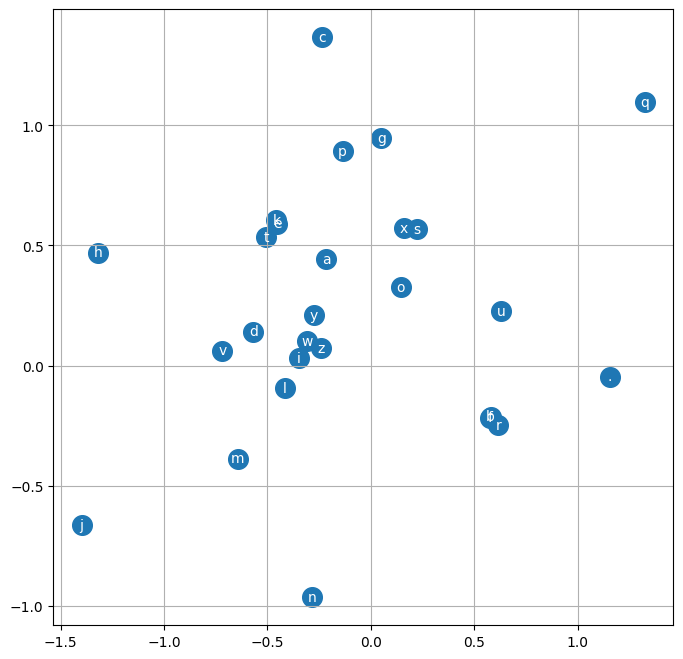

In [34]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [35]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
    #   print(emb)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
med.
rylle.
emman.
ejdoleg.
azeled.
eli.
jemilopaleigh.
estanara.
myki.
hotalin.
shravrichimies.
kin.
renleigh.
berlyn.
breyven.
jamyle.
eli.
